In [1]:
import logging
import json
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
wandb.login() 

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

#### load annotations

In [3]:
a = sc.read_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')
a

AnnData object with n_obs × n_vars = 3940 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'nuclei_segmentation_1X_notrim', 'nuclei_segmentation_1X_trimmed', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'segmented_nuclei_coords', 'segmented_nuclei_coords_1X_notrim', 'segmented_nuclei_coords_1X_trimmed', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

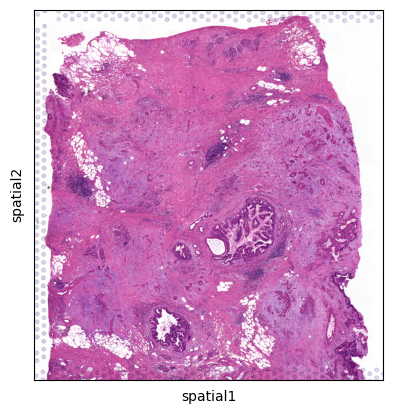

In [4]:
sc.pl.spatial(a)

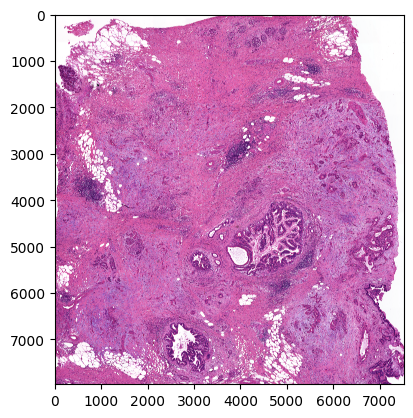

In [5]:
plt.imshow(a.uns['rescaled_he']['2X_trimmed'])

In [6]:
# import tifffile
# tifffile.imwrite('../data/annotations/pdac/HT270P1-S1H1U1_1X_trimmed.tiff', a.uns['rescaled_he']['1X_trimmed'])

In [7]:
scale = 2 # scale from full_res

In [8]:
ls = json.load(open('../data/annotations/pdac/HT270P1-S1H1U1_1X_trimmed.geojson'))['features']
label_to_pts = {}
for d in ls:
    coords = np.asarray(d['geometry']['coordinates']) // scale
    label = d['properties']['classification']['name']
    label_to_pts[label] = np.asarray(coords, dtype=np.int32)
label_to_pts

{'Immune cells': array([[3969, 2898],
        [4009, 2946],
        [4007, 2954],
        [3943, 3005],
        [4035, 3054],
        [3938, 3028],
        [3888, 3029],
        [4075, 3068],
        [3982, 3098],
        [4102, 3142],
        [4168, 3155],
        [3770, 3284],
        [3829, 3301],
        [3680, 3189],
        [3658, 3084],
        [3687, 3050],
        [3758, 3122],
        [3742, 2879],
        [3654, 2935],
        [ 651, 3719],
        [ 703, 3602],
        [ 792, 3705],
        [ 765, 3709],
        [ 627, 3650],
        [ 568, 3709],
        [ 561, 3611],
        [ 705, 3595],
        [ 756, 3612],
        [ 708, 3749],
        [ 675, 3770],
        [ 692, 3489],
        [ 638, 3420],
        [ 801, 3478],
        [ 716, 3416],
        [ 652, 3291],
        [ 683, 3310],
        [ 825, 3204],
        [ 252, 3378],
        [ 208, 3330],
        [ 989, 5267],
        [2165, 6671],
        [2291, 6735],
        [2248, 6811],
        [2160, 6811],
        [2093, 6

In [9]:
data = []
labels = sorted(label_to_pts.keys())
for label, pts in label_to_pts.items():
    for c, r in pts:
        data.append([r, c, label, labels.index(label)])
coord_df = pd.DataFrame(data=data, columns=['row', 'col', 'label', 'label_idx'])
coord_df

,row,col,label,label_idx
0,2898,3969,Immune cells,4
1,2946,4009,Immune cells,4
2,2954,4007,Immune cells,4
3,3005,3943,Immune cells,4
4,3054,4035,Immune cells,4
...,...,...,...,...
1195,1405,4168,Fibroblast,3
1196,1543,4840,Fibroblast,3
1197,1665,5756,Fibroblast,3
1198,1673,5674,Fibroblast,3


In [10]:
def reflection_mosiac(x, border=256):
    max_r, max_c = x.shape[-2], x.shape[-1]
    mosaic = torch.zeros((x.shape[0], max_r + (border * 2), max_c + (border * 2)), dtype=x.dtype)
    
    # make tiles
    top_left = TF.pad(x, padding=[border, border, 0, 0], padding_mode='reflect')
    top_right = TF.pad(x, padding=[0, border, border, 0], padding_mode='reflect')
    bottom_left = TF.pad(x, padding=[border, 0, 0, border], padding_mode='reflect')
    bottom_right = TF.pad(x, padding=[0, 0, border, border], padding_mode='reflect')
    
    mosaic[:, :max_r + border, :max_c + border] = top_left
    mosaic[:, :max_r + border, border:] = top_right
    mosaic[:, border:, :max_c + border] = bottom_left
    mosaic[:, border:, border:] = bottom_right
    
    return mosaic

In [11]:
border = 64
context_rescale_factor = 4
exp_rescale_factor = 1
exp_img = torch.load('../data/annotations/pdac/HT270P1-S1H1U1_exp.pt')
exp_img = rearrange(exp_img, 'h w c -> c h w')
exp_context_img = TF.resize(exp_img,
                            size=(exp_img.shape[1] // context_rescale_factor,
                                  exp_img.shape[2] // context_rescale_factor))
exp_img = reflection_mosiac(exp_img, border=border)
exp_context_img = reflection_mosiac(exp_context_img, border=border)
exp_img = TF.convert_image_dtype(exp_img, dtype=torch.float32)
exp_context_img = TF.convert_image_dtype(exp_context_img, dtype=torch.float32)

exp_genes = ['BGN',
 'CD14',
 'FCGR3A',
 'HLA-DRA',
 'IL7R',
 'INS',
 'ITGAX',
 'KRT18',
 'PECAM1',
 'PRSS1']

In [12]:
# exp_rescale_factor = 32
# exp_img = torch.load('../data/annotations/pdac/HT270P1-S1H1U1_meta_8x8.pt')
# exp_img = TF.convert_image_dtype(exp_img, dtype=torch.float32)
# exp_img = rearrange(exp_img, 'h w c -> c h w')

# exp_genes = list(range(exp_img.shape[0]))

In [13]:
# for i in range(len(exp_genes)):
#     plt.imshow(exp_img[i])
#     plt.title(i)
#     plt.show()

In [14]:
exp_img.shape, exp_context_img.shape

(torch.Size([10, 8096, 7652]), torch.Size([10, 2120, 2009]))

In [15]:
assert len(exp_genes) == exp_img.shape[0]

In [16]:
he_img = torch.tensor(a.uns['rescaled_he'][f'{scale}X_trimmed'], dtype=torch.uint8)
he_img = rearrange(he_img, 'h w c -> c h w')
he_img = reflection_mosiac(he_img, border=border)
he_img = TF.convert_image_dtype(he_img, dtype=torch.float32)
he_img.shape, he_img.max()

(torch.Size([3, 8096, 7652]), tensor(1.))

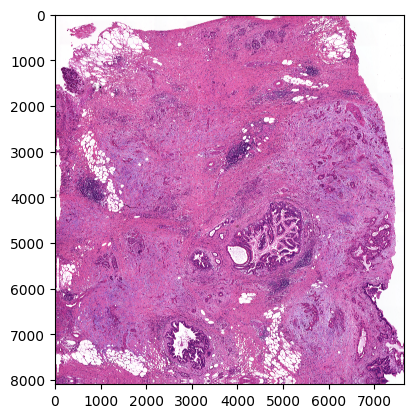

In [17]:
plt.imshow(rearrange(he_img, 'c h w -> h w c'))

In [18]:
assert exp_img.shape[1:] == he_img.shape[1:]

In [19]:
he_context_img = torch.tensor(a.uns['rescaled_he'][f'{scale * context_rescale_factor}X_trimmed'], dtype=torch.uint8)
he_context_img = rearrange(he_context_img, 'h w c -> c h w')
he_context_img = reflection_mosiac(he_context_img, border=border)
he_context_img = TF.convert_image_dtype(he_context_img, dtype=torch.float32)
he_context_img.shape, he_context_img.max()

(torch.Size([3, 2120, 2009]), tensor(1.))

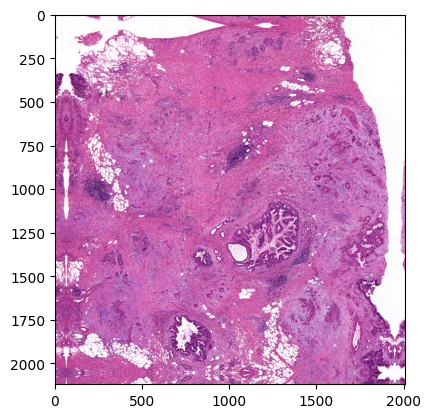

In [20]:
plt.imshow(rearrange(he_context_img, 'c h w -> h w c'))

###### check points

In [ ]:
x = rearrange(he_img, 'c h w -> h w c')
ex = rearrange(exp_img, 'c h w -> h w c')
for r, c, l in list(zip(coord_df['row'], coord_df['col'], coord_df['label']))[90:100]:
    r1, r2 = r - 32, r + 32
    c1, c2 = c - 32, c + 32
    plt.imshow(x[r1:r2, c1:c2])
    plt.title(l)
    plt.show()
    
    
#     r1, r2 = r // exp_rescale_factor - 32, r // exp_rescale_factor + 32
#     c1, c2 = c // exp_rescale_factor - 32, c // exp_rescale_factor + 32
#     print(r1, r2, c1, c2)
    
#     plt.imshow(ex[r1:r2, c1:c2, 2])
#     plt.title(l)
#     plt.show()
    
#     r1, r2 = r1 * exp_rescale_factor, r2 * exp_rescale_factor
#     c1, c2 = c1 * exp_rescale_factor, c2 * exp_rescale_factor
#     plt.imshow(x[r1:r2, c1:c2])
#     plt.title(l)
#     plt.show()
    

#### make dataloaders

In [21]:
class HETransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3, normalize=True):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
 
        self.p = p
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            keys = list(he.keys())
            hes = [he[k] for k in keys]
            masks = [mask[k] for k in keys]
            return_type = 'dict'
        else:
            hes = he
            masks = mask
            return_type = 'list'
                                
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(-self.hue, self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            
            # vertical and horizontal flips happen with p=.5
            do_hflip, do_vflip = torch.rand(size=(2,)) < .5 
            if do_hflip:
                hes = [TF.hflip(x) for x in hes]
                masks = [TF.hflip(x) for x in masks]
            if do_vflip:
                hes = [TF.vflip(x) for x in hes]
                masks = [TF.vflip(x) for x in masks]
        
        # normalize he
        hes = [self.normalize(x) for x in hes]
                    
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(keys, hes)}, {k:v for k, v in zip(keys, masks)}
        return hes, masks

In [22]:
def get_tile(img, r, c, tile_size=64):
    r1 = r - tile_size // 2
    c1 = c - tile_size // 2
    return TF.crop(img, r1, c1, height=tile_size, width=tile_size)
    
    return img[:, r1:r2, c1:c2]
    
class MergedDataset(Dataset):
    def __init__(self, he, he_context, exp, exp_context, nuclei_coords,
                 he_transform=None, labels=None, tile_size=64, border=0,
                 context_rescale_factor=4, exp_rescale_factor=1):
        super().__init__()
        self.he = he # (c h w), 0-1.
        self.he_context = he_context
        self.exp = exp # (c h w), 0-1.
        self.exp_context = exp_context
        self.coords = nuclei_coords
        self.tile_size = tile_size
        self.exp_rescale_factor = exp_rescale_factor
        self.context_rescale_factor = context_rescale_factor
        self.border = border
        
        self.he_transform = he_transform
        
        self.labels = labels
        
        if self.labels is not None:
            self.y = F.one_hot(labels).to(torch.float32)

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        
        r, c = self.coords[idx]
        he_tile = get_tile(self.he, r + border, c + border, tile_size=self.tile_size)
        
        context_r, context_c = r // self.context_rescale_factor, c // self.context_rescale_factor
        he_context_tile = get_tile(self.he_context, context_r + border, context_c + border,
                                   tile_size=self.tile_size)
        
        exp_r, exp_c = r // self.exp_rescale_factor, c // self.exp_rescale_factor
        exp_tile = get_tile(self.exp, exp_r + border, exp_c + border, tile_size=self.tile_size)
        
        offset = self.exp_rescale_factor * self.context_rescale_factor
        context_r, context_c = r // offset, c // offset
        exp_context_tile = get_tile(self.exp_context, context_r + border, context_c + border, tile_size=self.tile_size)
        
        if self.he_transform is not None:
            hes = [he_tile, he_context_tile]
            exps = [exp_tile, exp_context_tile]
            (he_tile, he_context_tile), (exp_tile, exp_context_tile) = self.he_transform(hes, exps)

        return {
            'he': he_tile,
            'he_context': he_context_tile,
            'exp': exp_tile,
            'exp_context': exp_context_tile,
            'y': torch.tensor([0]) if self.labels is None else self.y[idx],
            'r': r,
            'c': c
        }

In [23]:
train_he_transform = HETransform(p=.95, brightness=.1, contrast=.1, saturation=.1, hue=.1, normalize=True)
val_he_transform = HETransform(p=0.0, normalize=True)

In [24]:
tile_size = 64

In [25]:
train_ds = MergedDataset(
    he_img, he_context_img, exp_img, exp_context_img, coord_df[['row', 'col']].values, tile_size=tile_size,
    he_transform=train_he_transform, labels=torch.tensor(coord_df['label_idx'].to_numpy()),
    exp_rescale_factor=exp_rescale_factor, context_rescale_factor=context_rescale_factor,
    border=border
)
len(train_ds)

1200

In [26]:
val_ds = MergedDataset(
    he_img, he_context_img, exp_img, exp_context_img, coord_df[['row', 'col']].values, tile_size=tile_size,
    he_transform=val_he_transform, labels=torch.tensor(coord_df['label_idx'].to_numpy()),
    exp_rescale_factor=exp_rescale_factor, context_rescale_factor=context_rescale_factor, border=border
)
len(val_ds)

1200

In [27]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [28]:
%%time
batch = next(iter(train_dl))

CPU times: user 12.4 s, sys: 2.52 s, total: 14.9 s
Wall time: 13.3 s


In [29]:
batch['he'].shape, batch['exp'].shape, batch['y'].shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 10, 64, 64]),
 torch.Size([32, 6]))

###### inspect batch

In [ ]:
for i in range(10):
    img = rearrange(batch['he'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.title(labels[batch['y'][i].argmax()])
    plt.show()
    
    img = rearrange(batch['exp'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, exp_genes.index('KRT18')])
    plt.show()
    
    img = rearrange(batch['he_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.show()
    
    img = rearrange(batch['exp_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, exp_genes.index('KRT18')])
    plt.show()

#### model

In [30]:
class CellClassifier(nn.Module):
    def __init__(self, tile_size, n_exp_channels, n_classes, n_latent=1000):
        super().__init__()
        
        self.tile_size = tile_size
        self.n_classes = n_classes
        self.n_latent = n_latent
        self.n_exp_channels = n_exp_channels
        
        self.encode_he = create_model('resnet18', num_classes=self.n_latent, in_chans=3)
        self.encode_he_context = create_model('resnet18', num_classes=self.n_latent, in_chans=3)
        self.encode_exp = create_model('resnet18', num_classes=self.n_latent, in_chans=self.n_exp_channels)
        self.encode_exp_context = create_model('resnet18', num_classes=self.n_latent, in_chans=self.n_exp_channels)
            
        self.prediction_head = nn.Sequential(
            nn.Linear(self.n_latent, 128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, self.n_classes),
            nn.Softmax(dim=-1)
        )
        
        self.loss = nn.CrossEntropyLoss()
        
    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)
    
    def forward(self, he_tile, he_context_tile, exp_tile, exp_context_tile):
        he_z = self.encode_he(he_tile)
        he_context_z = self.encode_he_context(he_context_tile)
        exp_z = self.encode_exp(exp_tile)
        exp_context_z = self.encode_exp_context(exp_context_tile)
        
        z = he_z + he_context_z + exp_z + exp_context_z
        
        probs = self.prediction_head(z)
        
        return probs

In [31]:
def log_intermediates(logger, batch, plot_genes,
                      y_pred, y_true,
                      n_samples=8, identifier='train'):
    model_genes = np.asarray(exp_genes)
    g2i = {g:i for i, g in enumerate(model_genes)}
    gene_idxs = np.asarray([g2i[g] for g in plot_genes])
    
    img = batch['he'][:n_samples].clone().detach()
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f"{identifier}/he",
        images=[img],
        caption=[f'{identifier} he']
    )
    
    img = batch['he_context'][:n_samples].clone().detach()
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f"{identifier}/he_context",
        images=[img],
        caption=[f'{identifier} he context']
    )

    recon = batch['exp'][:n_samples].clone().detach().to(torch.float16)
    recon = recon[:, gene_idxs, :, :]
    recon -= recon.min()
    recon /= recon.max()
    recon = rearrange(recon, 'b c h w -> c b 1 h w')
    logger.log_image(
        key=f"{identifier}/exp",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )
    
    recon = batch['exp_context'][:n_samples].clone().detach().to(torch.float16)
    recon = recon[:, gene_idxs, :, :]
    recon -= recon.min()
    recon /= recon.max()
    recon = rearrange(recon, 'b c h w -> c b 1 h w')
    logger.log_image(
        key=f"{identifier}/exp_context",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )
    
    img = y_pred.clone().detach().cpu().numpy()[:n_samples]
    df = pd.DataFrame(data=img, columns=labels)
    logger.log_text(
        key=f'{identifier}/probs',
        dataframe=df,
    )
    
    img = y_pred.clone().detach().cpu().numpy()[:n_samples]
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f'{identifier}/probs_df',
        images=[img],
        caption=['probs']
    )
    
    img = y_true.clone().detach().cpu().numpy()[:n_samples]
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f'{identifier}/true',
        images=[img],
        caption=['true']
    )
    

In [32]:
class CellClassifierLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-3, n_samples=16, plot_genes=['IL7R', 'KRT18', 'BGN', 'PECAM1', 'INS'],
                 train_epoch_fraction=.1):
        super().__init__()
        
        self.model = model
        self.lr = lr
        self.plot_genes = plot_genes
        self.n_samples = n_samples
        self.train_epoch_fraction = train_epoch_fraction
        
        self.save_hyperparameters(ignore=['model'])

    def training_step(self, batch, batch_idx):
        he, he_context, exp, exp_context, y = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y']
        probs = self.model(he, he_context, exp, exp_context)
        loss = self.model.calculate_loss(probs, y)
        self.log_dict({'train/loss': loss}, on_step=False, on_epoch=True, prog_bar=True)

        # only log % of training epochs
        if batch_idx == 0 and torch.rand(1).item() < self.train_epoch_fraction:
            log_intermediates(self.logger, batch, self.plot_genes,
                              probs, y,
                              n_samples=self.n_samples, identifier='train')
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        he, he_context, exp, exp_context, y = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y']
        probs = self.model(he, he_context, exp, exp_context)
        loss = self.model.calculate_loss(probs, y)
        self.log_dict({'val/loss': loss}, on_step=False, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
            log_intermediates(self.logger, batch, self.plot_genes,
                              probs, y,
                              n_samples=self.n_samples, identifier='val')
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

#### training

In [33]:
project = 'cell_classifier'
log_dir = '/scratch1/fs1/dinglab/estorrs/deep-spatial-genomics/logs'

In [34]:
from pytorch_lightning.loggers import WandbLogger
logger = WandbLogger(project=project, save_dir=log_dir)

In [35]:
# wandb.finish()

In [36]:
config = {
    'n_exp_channels': len(exp_genes),
    'exp_channels': exp_genes,
    'tile_size': tile_size,
    'labels': labels,
    'n_labels': len(labels),
    'latent_dim': 1000,
    'he_scale': '2X',
    'context_rescale_factor': context_rescale_factor,
    'exp_rescale_factor': exp_rescale_factor,
    'he_encoder': {
        'model': 'resnet18',
        'in_channels': 3,
    },
    'he_context_encoder': {
        'model': 'resnet18',
        'in_channels': 3,
    },
    'exp_encoder': {
        'model': 'resnet18',
        'in_channels': len(exp_genes),
    },
    'exp_context_encoder': {
        'model': 'resnet18',
        'in_channels': len(exp_genes),
    },
    'training': {
        'train_samples': ['a'],
        'val_samples': ['a'],
        'log_n_samples': 8,
        'max_epochs': 5,
        'check_val_every_n_epoch': 1,
        'log_train_fraction': 1.,
        'log_every_n_steps': 1,
        'accelerator': 'gpu',
        'devices': 1,
        'limit_train_batches': 1.,
        'limit_val_batches': 1.,
        'lr': 1e-3,
        'batch_size': batch_size,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [37]:
cc = CellClassifier(
    config['tile_size'],
    config['n_exp_channels'],
    config['n_labels'],
    n_latent=config['latent_dim']
)
model = CellClassifierLightning(
    cc, lr=config['training']['lr'],
    n_samples=config['training']['log_n_samples'],
    train_epoch_fraction=config['training']['log_train_fraction'],
    plot_genes=config['exp_channels']
)

In [38]:
trainer = pl.Trainer(
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    check_val_every_n_epoch=config['training']['check_val_every_n_epoch'],
    enable_checkpointing=False,
    limit_val_batches=config['training']['limit_val_batches'],
    limit_train_batches=config['training']['limit_train_batches'],
    log_every_n_steps=config['training']['log_every_n_steps'],
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [39]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | CellClassifier | 46.9 M
-----------------------------------------
46.9 M    Trainable params
0         Non-trainable params
46.9 M    Total params
187.789   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


###### predict slide

In [40]:
data = []
for r, c in a.uns['segmented_nuclei_coords_1X_trimmed'].to_numpy():
    data.append([r // scale, c // scale, 'unknown', 0])
pred_coord_df = pd.DataFrame(data=data, columns=['row', 'col', 'label', 'label_idx'])
pred_coord_df

,row,col,label,label_idx
0,4688,4860,unknown,0
1,2243,5527,unknown,0
2,2240,1435,unknown,0
3,3334,3632,unknown,0
4,2344,1318,unknown,0
...,...,...,...,...
120252,6731,1244,unknown,0
120253,2445,4233,unknown,0
120254,7330,4072,unknown,0
120255,3521,1641,unknown,0


In [41]:
# filter for middle
# mask = (pred_coord_df['row'] >= 512) & (he_img.shape[1] - pred_coord_df['row'] >= 512)
# pred_coord_df = pred_coord_df[mask]

# mask = (pred_coord_df['col'] >= 512) & (he_img.shape[2] - pred_coord_df['col'] >= 512)
# pred_coord_df = pred_coord_df[mask]

# pred_coord_df

In [42]:
pred_ds = MergedDataset(
    he_img, he_context_img, exp_img, exp_context_img, pred_coord_df[['row', 'col']].values, tile_size=tile_size,
    he_transform=val_he_transform, border=border,
    exp_rescale_factor=exp_rescale_factor, context_rescale_factor=context_rescale_factor
)
len(pred_ds)

120257

###### inspect batch

In [ ]:
%%time
batch = next(iter(pred_dl))

In [ ]:
for i in range(10):
    img = rearrange(batch['he'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.show()
    
    img = rearrange(batch['exp'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, exp_genes.index('KRT18')])
    plt.show()
    
    img = rearrange(batch['he_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.show()
    
    img = rearrange(batch['exp_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, exp_genes.index('KRT18')])
    plt.show()

#### predict dataset

In [43]:
bs = 512
pred_dl = DataLoader(pred_ds, batch_size=bs, shuffle=False)

In [44]:
# %%time
data = []

m = model.model
m = m.cuda()
m.eval()
with torch.no_grad():
    for j, batch in enumerate(pred_dl):
        if j % 10 == 0:
            print(j * bs)
        he, he_context, exp, exp_context, y, r, c = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y'], batch['r'], batch['c']
        y, r, c = y.clone().detach().numpy(), r.clone().detach().numpy(), c.clone().detach().numpy()

        if next(iter(model.parameters())).is_cuda:
            he, he_context, exp, exp_context = he.cuda(), he_context.cuda(), exp.cuda(), exp_context.cuda()
        probs = m(he, he_context, exp, exp_context).clone().detach().cpu().numpy()
        idxs = probs.argmax(axis=-1)
        pred_labels = [labels[i] for i in idxs]
        idxs = y.argmax(axis=-1)
        true_labels = [labels[i] for i in idxs]
        
        for i in range(probs.shape[0]):
            row = list(probs[i])
            row += [pred_labels[i], true_labels[i], r[i], c[i]]
            data.append(row)
cols = list(labels)
cols += ['predicted', 'true', 'row', 'col']
df = pd.DataFrame(data, columns=cols)
df

0
5120
10240
15360
20480
25600
30720
35840
40960
46080
51200
56320
61440
66560
71680
76800
81920
87040
92160
97280
102400
107520
112640
117760


,Endothelial,Epithelial,Erythrocyte,Fibroblast,Immune cells,Islet,predicted,true,row,col
0,3.659193e-05,1.063447e-03,1.074850e-04,6.502261e-05,9.024311e-01,9.629632e-02,Immune cells,Endothelial,4688,4860
1,5.871064e-28,1.000000e+00,4.962875e-24,2.433587e-30,1.329600e-22,4.221943e-24,Epithelial,Endothelial,2243,5527
2,1.605415e-35,1.684965e-35,0.000000e+00,2.949733e-42,1.556948e-35,1.000000e+00,Islet,Endothelial,2240,1435
3,4.803258e-07,9.929320e-01,5.777786e-12,4.194089e-11,2.740672e-09,7.067562e-03,Epithelial,Endothelial,3334,3632
4,2.606350e-09,1.454626e-12,6.527107e-12,1.093401e-08,4.097163e-05,9.999590e-01,Islet,Endothelial,2344,1318
...,...,...,...,...,...,...,...,...,...,...
120252,2.197003e-12,9.999985e-01,1.512398e-06,3.564852e-11,3.793589e-09,3.486422e-09,Epithelial,Endothelial,6731,1244
120253,3.371540e-04,5.354590e-06,6.255727e-06,5.208701e-01,1.387818e-05,4.787672e-01,Fibroblast,Endothelial,2445,4233
120254,1.104840e-04,7.524725e-06,1.032224e-04,1.568522e-02,7.978512e-04,9.832957e-01,Islet,Endothelial,7330,4072
120255,9.814746e-07,1.836767e-04,7.839716e-06,9.969451e-01,1.145870e-05,2.850858e-03,Fibroblast,Endothelial,3521,1641


In [ ]:
# from sklearn.metrics import f1_score
# f1_score(df['predicted'], df['true'], average='macro')

In [ ]:
# # %%time
# data = []
# model.eval()
# with torch.no_grad():
#     for j, batch in enumerate(pred_dl):
#         if j % 10 == 0:
#             print(j * 512)
#         he, he_context, exp, exp_context, y, r, c = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y'], batch['r'], batch['c']
#         y, r, c = y.clone().detach().numpy(), r.clone().detach().numpy(), c.clone().detach().numpy()
#         if next(iter(model.parameters())).is_cuda:
#             he, he_context, exp, exp_context = he.cuda(), he_context.cuda(), exp.cuda(), exp_context.cuda()
#         probs = model.model(he, he_context, exp, exp_context).clone().detach().cpu().numpy()
#         idxs = probs.argmax(axis=-1)
#         pred_labels = [labels[i] for i in idxs]
#         idxs = y.argmax(axis=-1)
#         true_labels = [labels[i] for i in idxs]
        
#         for i in range(probs.shape[0]):
#             row = list(probs[i])
#             row += [pred_labels[i], true_labels[i], r[i], c[i]]
#             data.append(row)
# cols = list(labels)
# cols += ['predicted', 'true', 'row', 'col']
# df = pd.DataFrame(data, columns=cols)
# df

In [ ]:
# x = rearrange(he_img, 'c h w -> h w c')
# for r, c, l in list(zip(df['row'], df['col'], df['predicted']))[:10]:
#     r, c = r + border, c + border
#     r1, r2 = r - 32, r + 32
#     c1, c2 = c - 32, c + 32
#     plt.imshow(x[r1:r2, c1:c2])
#     plt.title(l)
#     plt.show()

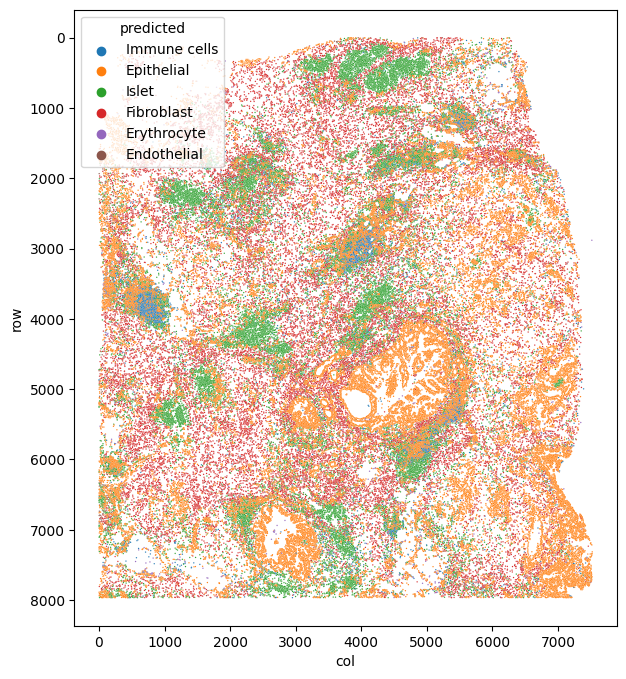

In [45]:
import seaborn as sns
mr, mc = he_img.shape[2] // 1000, he_img.shape[1] // 1000
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=df, x='col', y='row', hue='predicted', s=1, ax=ax)
ax.invert_yaxis()

In [ ]:
cr1, cc1 = 3500, 4200
cr2, cc2 = cr1 + 1000, cc1 + 1000

In [ ]:
f = df.copy()
f = f[((df['row']>cr1) & (df['row'] < cr2))]
f = f[((df['col']>cc1) & (df['col'] < cc2))]
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=f, x='col', y='row', hue='predicted', s=5, ax=ax)
ax.invert_yaxis()

In [ ]:
plt.imshow(rearrange(he_img, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
cr1, cc1 = 5500, 5800
cr2, cc2 = cr1 + 500, cc1 + 500

In [ ]:
f = df.copy()
f = f[((df['row']>cr1) & (df['row'] < cr2))]
f = f[((df['col']>cc1) & (df['col'] < cc2))]
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=f, x='col', y='row', hue='predicted', s=10, ax=ax)
ax.invert_yaxis()

In [ ]:
plt.imshow(rearrange(he_img, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
plt.imshow(rearrange(exp, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
plt.imshow(exp_img[exp_genes.index('KRT18'), cr1:cr2, cc1:cc2])

In [ ]:
cr1, cc1 = 5000, 3800
cr2, cc2 = cr1 + 1000, cc1 + 1000

In [ ]:
f = df.copy()
f = f[((df['row']>cr1) & (df['row'] < cr2))]
f = f[((df['col']>cc1) & (df['col'] < cc2))]
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=f, x='col', y='row', hue='predicted', s=10, ax=ax)
ax.invert_yaxis()

In [ ]:
plt.imshow(rearrange(he_img, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
plt.imshow(exp_img[exp_genes.index('KRT18'), cr1:cr2, cc1:cc2])